In [5]:
%matplotlib inline

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  Making Python Faster Part 2

**1**. (25 points) Accelerating network bound procedures.

- Print the names of the first 5 PNG images on the URL `http://people.duke.edu/~ccc14/misc/`. (10 points)
- Write a function that uses a for loop to download all images and time how long it takes (5 points)
- Write a function that uses `concurrent.futures` and a thread pool to download all images and time how long it takes (5 points)
- Write a function that uses `multiprocessing` and a process pool to download all images and time how long it takes (5 points)

In [41]:
import requests
from bs4 import BeautifulSoup

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + node.get('href') for node in soup.find_all('a') 
            if node.get('href').endswith(ext)]

site = 'http://people.duke.edu/~ccc14/misc/'
ext = 'png'
for i, file in enumerate(listFD(site, ext)):
    if i == 5:
        break
    print(file)

http://people.duke.edu/~ccc14/misc/250px-002Ivysaur.png
http://people.duke.edu/~ccc14/misc/250px-003Venusaur.png
http://people.duke.edu/~ccc14/misc/250px-004Charmander.png
http://people.duke.edu/~ccc14/misc/250px-005Charmeleon.png
http://people.duke.edu/~ccc14/misc/250px-006Charizard.png


In [38]:
def download_one(url, path):
    r = requests.get(url, stream=True)
    img = r.raw.read()
    with open(path, 'wb') as f:
        f.write(img) 

In [27]:
%%time

for url in listFD(site, ext):
    filename = os.path.split(url)[-1]
    download_one(url, filename)

CPU times: user 533 ms, sys: 129 ms, total: 661 ms
Wall time: 4.13 s


In [39]:
%%time

from concurrent.futures import ThreadPoolExecutor

args = [(url, os.path.split(url)[-1]) 
        for url in listFD(site, ext)]
with ThreadPoolExecutor(max_workers=4) as pool:
    pool.map(lambda x: download_one(x[0], x[1]), args)

CPU times: user 549 ms, sys: 156 ms, total: 705 ms
Wall time: 1.09 s


In [40]:
%%time

from multiprocessing import Pool

args = [(url, os.path.split(url)[-1]) 
        for url in listFD(site, ext)]
with Pool(processes=4) as pool:
    pool.starmap(download_one, args)

CPU times: user 79.6 ms, sys: 25.8 ms, total: 105 ms
Wall time: 1.12 s


**2**. (25 points) Accelerating CPU bound procedures

- Use the insanely slow [Buffon's needle](https://en.wikipedia.org/wiki/Buffon's_needle) algorithm to estimate $\pi$.  Suppose the needle is of length 1, and the lines are also 1 unit apart.  Write a function to simulate the dropping of a pin with a random position and random angle, and return 0 if it does not cross a line and 1 if it does. Since the problem is periodic, you can assume that the bottom of the pin falls within (0, 1) and check if it crosses the line `y=0` or `y=1`. (10 points)
- Calculate pi from dropping `n=10^6` pins and time it (10 points)
- Use `concurrent.futures` and a process pool to parallelize  your solution and time it.

In [52]:
n = 100
p = 10
xs = np.random.random((n, p))

In [53]:
def dist(x, y):
    return np.sqrt(np.sum((x - y)**2))

In [54]:
def pdist(xs):
    m = np.empty((len(xs), len(xs)))
    for i, x in enumerate(xs):
        for j, y in enumerate(xs):
            m[i, j] = dist(x, y)
    return m

In [55]:
%timeit pdist(xs)

10 loops, best of 3: 182 ms per loop


**3**. (25 points) Use C++ to

- Generate 10 $x$-coordinates linearly spaced between 10 and 15
- Generate 10 random $y$-values as $y = 3x^2 − 7x + 2 + \epsilon$ where $\epsilon∼10N(0,1)$
- Find the norm of $x$ and $y$ considered as length 10-vectors
- Find the Euclidean distance between $x$ and $y$
- Solve the linear system to find a quadratic fit for this data

You may wish to use `armadillo` or `eigen` to solve this exercise.

**4**. (25 points) **4**. Write a C++ function that uses the `eigen` library to solve the least squares linear problem

$$
\beta = (X^TX)^{-1}X^Ty
$$

for a matrix $X$ and vector $y$ and returns the vector of coefficients $\beta$. Wrap the function for use in Python and call it like so

```
beta <- least_squares(X, y)
```

where $X$ and $y$ are given below. 

Wrap the function so that it can be called from Python and compare with the `np.linalg.lstsq` solution shown.

In [11]:
n = 10
x = np.linspace(0, 10, n)
y = 3*x**2 - 7*x + 2 + np.random.normal(0, 10, n)
X = np.c_[np.ones(n), x, x**2]

In [12]:
beta = np.linalg.lstsq(X, y)[0]

In [13]:
beta

array([-0.1395432 , -6.31852515,  2.90852583])

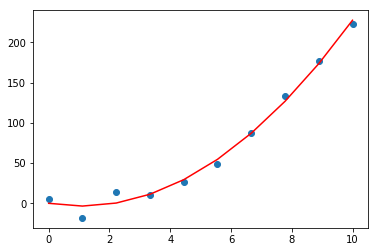

In [14]:
plt.scatter(x, y)
plt.plot(x, X @ beta, 'red')
pass